# **Neuropolis: Building an artificial intelligence system for human brain activity prediction (EEG, fMRI)**

#### Version: 10th March 2024

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through nine Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Linear Regression*

*04: KNN, Decision Trees, Random Forests, SVM*

***05: Neural Networks***

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Human Brain Predictability Map*

==============================================================================================

### Notebook 05

# **Neural Networks**

## **1. Classification**

- **Task**: We train a neural network model on a classification task, on all subjects except sub-xp102 who has a missing condition. Specifically, our objective is to predict the block type, task or rest. The succession of block types is the same for all subjects and all conditions. 

- **Model**: We use a succession of Dense layers with the Stochastic Gradient Descent (SGD) optimizer and the categorical cross-entropy loss. Our objective is to maximize the classification score. 

- **Strategies**: In the Predictor Brains strategy, we use the eegfmriNF condition as the train set, the eegNF condition as the validation set, and the fmriNF condition as the test set, individually for each subject. In the Predictor Groups strategy, we use all the conditions of eight subjects as the train and validation set, and all the conditions of the remaining ninth subject as the test set, and we repeat this process nine times in order to make predictions for the nine subjects. 

- **Results**: The neural network model predicts the block type with a probability higher than the baseline, both for the Predictor Brains strategy and the Predictor Groups strategy. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# Define the raw data path. 
raw_data_path = '../ds002336-download/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis_results/'

In [3]:
# Load the features, the targets, and the baseline. 
with open(preprocessed_data_path + 'features/dict_features_sequence.p', 'rb') as file:
    dict_features_sequence = pickle.load(file)
with open(preprocessed_data_path + 'targets/dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'targets/dict_targets_sequence.p', 'rb') as file:
    dict_targets_sequence = pickle.load(file)
with open(preprocessed_data_path + 'baseline/dict_baseline_sequence.p', 'rb') as file:
    dict_baseline_sequence = pickle.load(file)

In [4]:
# Define the list of subjects, removing sub-xp102 who has a missing condition. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subjects.remove('sub-xp102')
subject = subjects[0]

# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Select a sequence length. 
selected_sequence_length = 5

# Retrieve the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['pgACC'].shape[0]

# Define the batch size for the neural networks models. 
batch_size = 32

In [5]:
# Retrieve and display the events file. 
events = pd.read_csv(raw_data_path + 'task-eegfmriNF_events.tsv', sep = '\t')
events

,onset,duration,trial_type,stim_file
0,2,20,Rest,Rest_Xp1.png
1,22,20,Task-NF,Task-NF_Xp1.png
2,42,20,Rest,Rest_Xp1.png
3,62,20,Task-NF,Task-NF_Xp1.png
4,82,20,Rest,Rest_Xp1.png
5,102,20,Task-NF,Task-NF_Xp1.png
6,122,20,Rest,Rest_Xp1.png
7,142,20,Task-NF,Task-NF_Xp1.png
8,162,20,Rest,Rest_Xp1.png
9,182,20,Task-NF,Task-NF_Xp1.png


In [6]:
# Define and display the target for classification. 
y_basis = np.repeat(np.tile([0, 1], 10), 10)
y_sequence = y_basis[selected_sequence_length:]
print(y_sequence)

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1]


In [7]:
# Create a baseline containing only the most frequent value. 
most_frequent_value = np.bincount(y_sequence.astype(int)).argmax()
neural_networks_baseline = np.sum(y_sequence.astype(int) == most_frequent_value) / y_sequence.shape[0]
neural_networks_baseline

0.5128205128205128

In [8]:
# Define a function to run a neural network model for the Predictor Brains strategy, for a classification task. 
def run_neural_network_predictor_brains_classification(NeuralNetworkModel, dict_features_sequence, y_sequence):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the features and targets of the train set, validation set, and test set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        X_va = dict_features_sequence[subject]['eegNF']
        X_te = dict_features_sequence[subject]['fmriNF']
        y_tr = y_va = y_te = y_sequence

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_standardized = scaler.fit_transform(X_tr)
        X_va_standardized = scaler.transform(X_va)
        X_te_standardized = scaler.transform(X_te)

        # Encode target variable et retrieve the encoding order. 
        y_tr_encoded = pd.get_dummies(y_tr)
        y_va_encoded = pd.get_dummies(y_va)
        y_te_encoded = pd.get_dummies(y_te)
        encoding_order = np.unique(y_te)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

        # Define the loss function, optimizer, and metrics to track during training. 
        PredictorBrain.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = y_tr_encoded,
            validation_data = (X_va_standardized, y_va_encoded), 
            batch_size = batch_size, epochs = 50,
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test score. 
        (loss_test, score_test) = PredictorBrain.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

        # Compute the predictions from the neural network, and compute the accuracy from these predictions. 
        y_pred = encoding_order[np.where(PredictorBrain.predict(X_te_standardized) > 0.5)[1]]

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'loss_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'loss_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'loss_test'] = loss_test
        df_summary.loc[subject, 'score_train'] = NeuralNetworkHistory.history['acc'][-1]
        df_summary.loc[subject, 'score_valid'] = NeuralNetworkHistory.history['val_acc'][-1]
        df_summary.loc[subject, 'score_test'] = score_test
        df_summary.loc[subject, 'score_baseline'] = neural_networks_baseline
        df_summary.loc[subject, 'above_baseline'] = str(score_test > neural_networks_baseline)
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'y_tr.shape'] = str(y_tr_encoded.shape)
        df_summary.loc[subject, 'y_va.shape'] = str(y_va_encoded.shape)
        df_summary.loc[subject, 'y_te.shape'] = str(y_te_encoded.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = y_pred
    
    return dict_models, dict_history, dict_predictions, df_summary

In [9]:
# Define a function to run a neural network model for the Predictor Groups strategy, for a classification task. 
def run_neural_network_predictor_groups_classification(NeuralNetworkModel, dict_features_sequence, y_sequence):

    # Determine the proportion of the validation set. 
    validation_set_proportion = 0.3

    # Define the dictionaries and the summary DataFrame. 
    dict_scaler = dict()
    dict_shapes = dict()
    dict_mean_baseline = dict()
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # TRAINING LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorGroup = tf.keras.models.clone_model(NeuralNetworkModel)

        # Define the lists to store the features, targets, and baseline for the train+valid set. 
        features_list = []
        targets_list = []
        baseline_list = []

        # Iterate through all subjects, except for the subject whose targets we are trying to predict. 
        for subject_predictor in subjects:

            # Skip the current iteration for the current subject. 
            if subject_predictor == subject:
                continue

            # Iterate through all conditions. 
            for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

                # Retrieve the features, targets, and baseline, and add them to the list. 
                features_list.append(dict_features_sequence[subject_predictor][condition])
                targets_list.append(y_sequence)
                baseline_list.append(dict_baseline_sequence[subject_predictor][condition])
        
        # Retrieve the features, targets, and baseline of the train+validation set. 
        X = np.vstack(features_list)
        y = np.hstack(targets_list)
        Baseline = np.array(baseline_list).mean(axis = 0)

        # Divide the data into a train set and a validation set. 
        X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size = validation_set_proportion)

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_standardized = scaler.fit_transform(X_tr)
        X_va_standardized = scaler.transform(X_va)

        # Encode target variable. 
        y_tr_encoded = pd.get_dummies(y_tr)
        y_va_encoded = pd.get_dummies(y_va)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

        # Define the loss function, optimizer, and metrics to track during training. 
        PredictorGroup.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

        # Fit the model. 
        NeuralNetworkHistory = PredictorGroup.fit(
            x = X_tr_standardized, y = y_tr_encoded,
            validation_data = (X_va_standardized, y_va_encoded), 
            batch_size = batch_size, epochs = 20, 
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Store the scaler, shapes of arrays, mean baseline, trained model, and history in dictionaries. 
        dict_scaler[subject] = scaler
        dict_shapes[subject] = [X_tr_standardized.shape, X_va_standardized.shape, y_tr_encoded.shape, y_va_encoded.shape]
        dict_mean_baseline[subject] = Baseline
        dict_models[subject] = PredictorGroup
        dict_history[subject] = NeuralNetworkHistory

    # PREDICTION LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Define the subject dictionary. 
        dict_predictions[subject] = dict()

        # Iterate through all conditions. 
        for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

            # Retrieve the features and targets of the test set, the baseline, the trained model, and the history. 
            X_te = dict_features_sequence[subject][condition]
            y_te = y_sequence
            Baseline = dict_mean_baseline[subject]
            PredictorGroup = dict_models[subject]
            NeuralNetworkHistory = dict_history[subject]

            # Rescale features variables. 
            scaler = dict_scaler[subject]
            X_te_standardized = scaler.transform(X_te)

            # Encode target variable and retrieve the encoding order. 
            y_te_encoded = pd.get_dummies(y_te)
            encoding_order = np.unique(y_tr)

            # Evaluate the test score. 
            (loss_test, score_test) = PredictorGroup.evaluate(X_te_standardized, y_te_encoded, batch_size = batch_size)

            # Compute the predictions from the neural network, and compute the accuracy from these predictions. 
            y_pred = encoding_order[np.where(PredictorGroup.predict(X_te_standardized) > 0.5)[1]]

            # Retrieve the shapes of the arrays from the train set. 
            [X_tr_shape, X_va_shape, y_tr_shape, y_va_shape] = dict_shapes[subject]

            # Store the performance metrics and the shapes of the arrays in the DataFrame. 
            df_summary.loc[subject + '/' + condition, 'subject'] = subject
            df_summary.loc[subject + '/' + condition, 'condition'] = condition
            df_summary.loc[subject + '/' + condition, 'loss_train'] = NeuralNetworkHistory.history['loss'][-1]
            df_summary.loc[subject + '/' + condition, 'loss_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
            df_summary.loc[subject + '/' + condition, 'loss_test'] = loss_test
            df_summary.loc[subject + '/' + condition, 'score_train'] = NeuralNetworkHistory.history['acc'][-1]
            df_summary.loc[subject + '/' + condition, 'score_valid'] = NeuralNetworkHistory.history['val_acc'][-1]
            df_summary.loc[subject + '/' + condition, 'score_test'] = score_test
            df_summary.loc[subject + '/' + condition, 'score_baseline'] = neural_networks_baseline
            df_summary.loc[subject + '/' + condition, 'above_baseline'] = str(score_test > neural_networks_baseline)
            df_summary.loc[subject + '/' + condition, 'X_tr.shape'] = str(X_tr_shape)
            df_summary.loc[subject + '/' + condition, 'X_va.shape'] = str(X_va_shape)
            df_summary.loc[subject + '/' + condition, 'X_te.shape'] = str(X_te_standardized.shape)
            df_summary.loc[subject + '/' + condition, 'y_tr.shape'] = str(y_tr_shape)
            df_summary.loc[subject + '/' + condition, 'y_va.shape'] = str(y_va_shape)
            df_summary.loc[subject + '/' + condition, 'y_te.shape'] = str(y_te_encoded.shape)

            # Store the predictions in the dictionary. 
            dict_predictions[subject][condition] = y_pred

    # Change the indexes of the DataFrame. 
    df_summary = df_summary.set_index(['subject', 'condition'])
    
    return dict_models, dict_history, dict_predictions, df_summary

In [10]:
# Define a function to plot the results of the neural network training. 
def plot_neural_network_classification(dict_history_class, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_class[subject]

        # Plot loss values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train loss', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val loss', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. loss: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('Loss value')
        axes[subject_index, 0].legend()

        # Plot accuracy values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['acc'], label = 'train acc', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_acc'], label = 'val acc', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. accuracy: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_acc'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('Accuracy')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [11]:
# Define the neural network model. 
tf.random.set_seed(0)
NeuralNetworkModel = tf.keras.Sequential()

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 4096, activation = tf.keras.activations.relu, input_dim = dict_features_sequence[subject]['eegfmriNF'].shape[1],
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5, seed = 0))

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 1024, activation = tf.keras.activations.relu, 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5, seed = 0))

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 256, activation = tf.keras.activations.relu, 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5, seed = 0))

# Output layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 2, activation = tf.keras.activations.softmax,
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Print network summary. 
NeuralNetworkModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              9293824   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 5

In [12]:
# Run the neural network model. 
dict_models_pb_class, dict_history_pb_class, dict_predictions_pb_class, df_summary_pb_class = run_neural_network_predictor_brains_classification(NeuralNetworkModel, 
                                                                                                                                                 dict_features_sequence, 
                                                                                                                                                 y_sequence)

sub-xp101


2024-03-10 13:50:50.506387: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 0s 5ms/step
sub-xp103
7/7 [==============================] - 0s 4ms/step
sub-xp104
7/7 [==============================] - 0s 4ms/step
sub-xp105
7/7 [==============================] - 0s 3ms/step
sub-xp106
7/7 [==============================] - 0s 4ms/step
sub-xp107
7/7 [==============================] - 0s 5ms/step
sub-xp108
7/7 [==============================] - 0s 3ms/step
sub-xp109
7/7 [==============================] - 0s 4ms/step
sub-xp110
7/7 [==============================] - 0s 4ms/step


In [13]:
# Display the results. 
print('Neural Networks: Predictor Brains, Classification')
df_summary_pb_class

Neural Networks: Predictor Brains, Classification


,loss_train,loss_valid,loss_test,score_train,score_valid,score_test,score_baseline,above_baseline,X_tr.shape,X_va.shape,X_te.shape,y_tr.shape,y_va.shape,y_te.shape
sub-xp101,93.720924,95.037140,95.769127,0.974359,0.625641,0.528205,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"
sub-xp103,93.738060,94.470787,95.064766,0.974359,0.697436,0.548718,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"
sub-xp104,93.715546,93.846436,94.041138,0.974359,0.851282,0.810256,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"
sub-xp105,93.720795,95.337227,94.992615,0.979487,0.589744,0.682051,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"
sub-xp106,93.715614,94.570793,94.563599,0.969231,0.676923,0.641026,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"
sub-xp107,93.719063,94.389015,94.349442,0.969231,0.676923,0.702564,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"
sub-xp108,93.706398,94.442085,94.102493,0.974359,0.743590,0.856410,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"
sub-xp109,93.726242,94.419281,94.319138,0.974359,0.692308,0.687180,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"
sub-xp110,93.745590,94.970650,94.621521,0.964103,0.528205,0.620513,0.512821,True,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 2)","(195, 2)","(195, 2)"


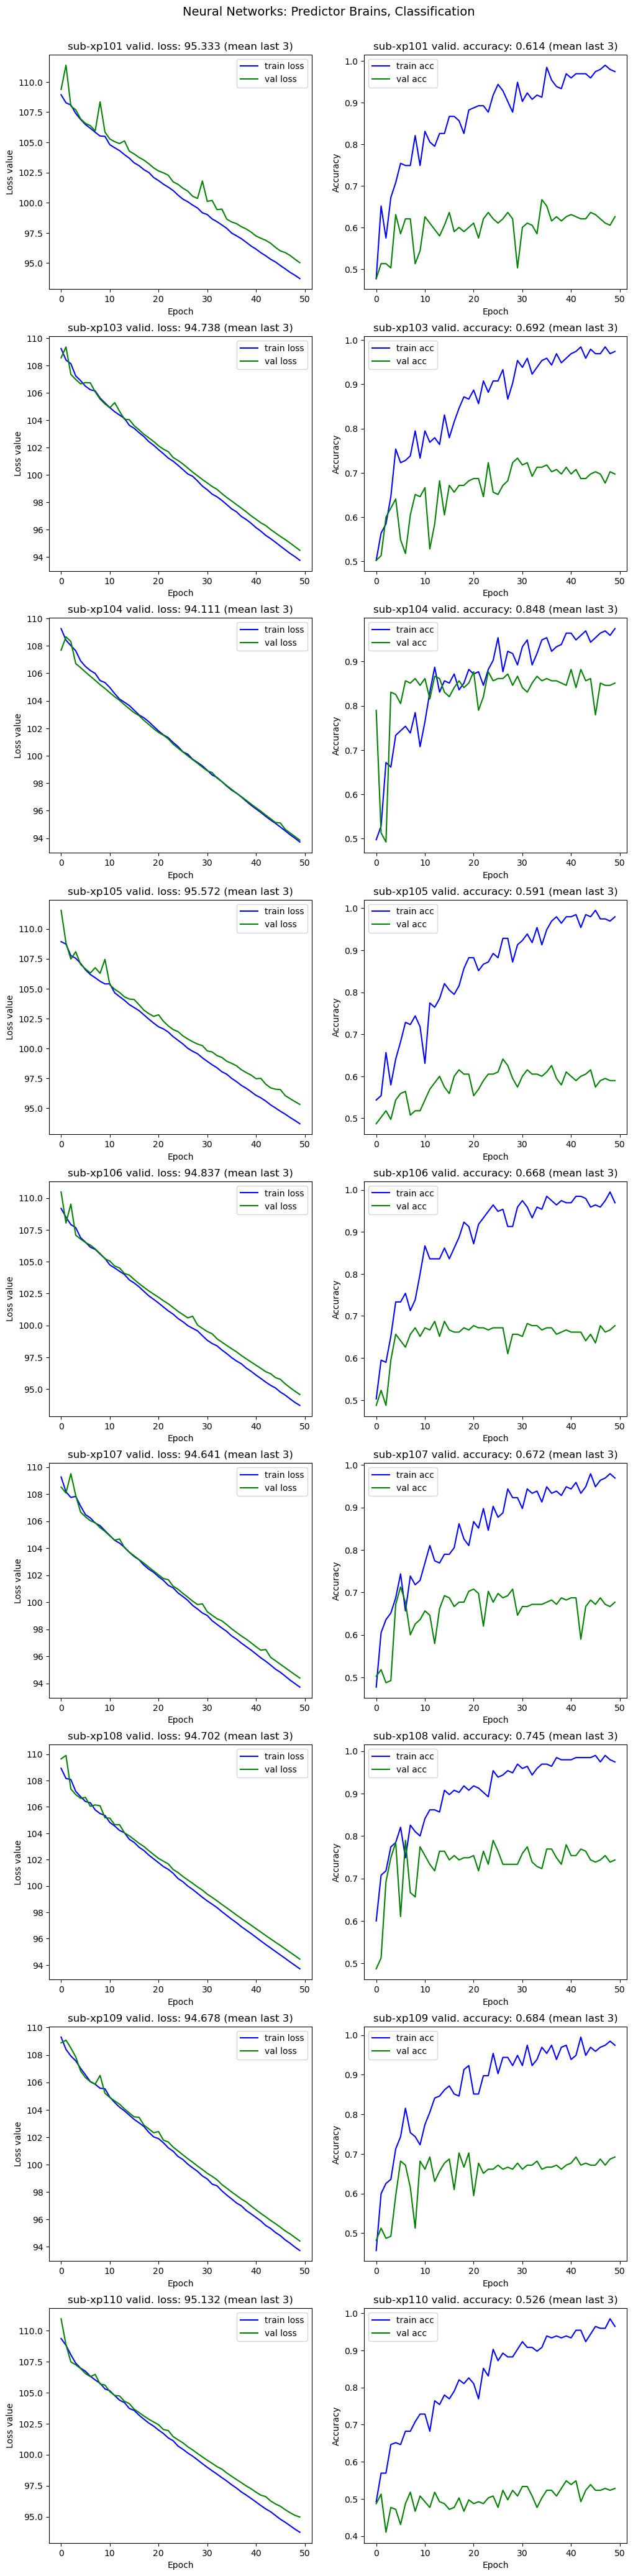

In [14]:
# Display the results. 
plot_neural_network_classification(dict_history_pb_class, title = 'Neural Networks: Predictor Brains, Classification')

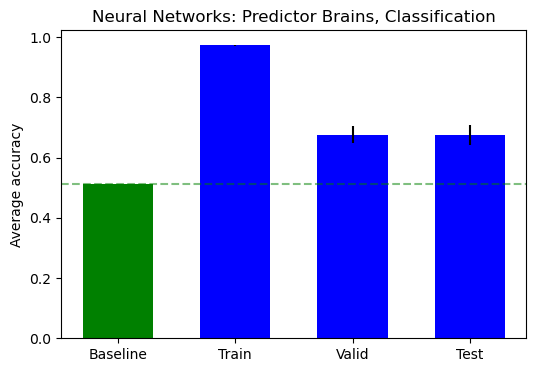

In [15]:
# Retrieve the average accuracy and the standard error of the accuracy. 
acc = [df_summary_pb_class['score_baseline'].mean(), 
       df_summary_pb_class['score_train'].mean(), 
       df_summary_pb_class['score_valid'].mean(), 
       df_summary_pb_class['score_test'].mean()]
acc_se = [np.std(df_summary_pb_class['score_baseline']) / np.sqrt(df_summary_pb_class['score_baseline'].shape[0]), 
          np.std(df_summary_pb_class['score_train']) / np.sqrt(df_summary_pb_class['score_train'].shape[0]), 
          np.std(df_summary_pb_class['score_valid']) / np.sqrt(df_summary_pb_class['score_valid'].shape[0]), 
          np.std(df_summary_pb_class['score_test']) / np.sqrt(df_summary_pb_class['score_test'].shape[0])]

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average accuracy')
axes.set_title('Neural Networks: Predictor Brains, Classification');

In [16]:
# Run the neural network model. 
dict_models_pg_class, dict_history_pg_class, dict_predictions_pg_class, df_summary_pg_class = run_neural_network_predictor_groups_classification(NeuralNetworkModel, 
                                                                                                                                                 dict_features_sequence, 
                                                                                                                                                 y_sequence)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110
7/7 [==============================] - 0s 3ms/step


In [17]:
# Display the results. 
print('Neural Networks: Predictor Groups, Classification')
df_summary_pg_class

Neural Networks: Predictor Groups, Classification


loss_train  loss_valid  loss_test  score_train  \
subject   condition                                                   
sub-xp101 eegNF       48.595985   47.746979  47.964958     0.805556   
          fmriNF      48.595985   47.746979  47.904964     0.805556   
          eegfmriNF   48.595985   47.746979  47.929260     0.805556   
sub-xp103 eegNF       48.604713   47.742611  47.756104     0.798840   
          fmriNF      48.604713   47.742611  47.951729     0.798840   
          eegfmriNF   48.604713   47.742611  47.856049     0.798840   
sub-xp104 eegNF       48.614838   47.757889  47.591888     0.796703   
          fmriNF      48.614838   47.757889  47.630871     0.796703   
          eegfmriNF   48.614838   47.757889  47.708389     0.796703   
sub-xp105 eegNF       48.589458   47.761490  48.079433     0.805250   
          fmriNF      48.589458   47.761490  47.853321     0.805250   
          eegfmriNF   48.589458   47.761490  48.009945     0.805250   
sub-xp106 eegNF       48.591042   47.750271  47.786118     0.807692   
          fmriNF      48.591042   47.750271  47.919197     0.807692   
          eegfmriNF   48.591042   47.750271  47.862606     0.807692   
sub-xp107 eegNF       48.588421   47.735798  47.930470     0.805861   
          fmriNF      48.588421   47.735798  47.989750     0.805861   
          eegfmriNF   48.588421   47.735798  47.822853     0.805861   
sub-xp108 eegNF       48.610397   47.765240  47.743759     0.793956   
          fmriNF      48.610397   47.765240  47.732471     0.793956   
          eegfmriNF   48.610397   47.765240  47.606178     0.793956   
sub-xp109 eegNF       48.624352   47.723156  47.755886     0.786020   
          fmriNF      48.624352   47.723156  47.810497     0.786020   
          eegfmriNF   48.624352   47.723156  47.742767     0.786020   
sub-xp110 eegNF       48.601753   47.738533  47.895672     0.800977   
          fmriNF      48.601753   47.738533  47.885647     0.800977   
          eegfmriNF   48.601753   47.738533  47.835236     0.800977   

                     score_valid  score_test  score_baseline above_baseline  \
subject   condition                                                           
sub-xp101 eegNF         0.732906    0.538462        0.512821           True   
          fmriNF        0.732906    0.630769        0.512821           True   
          eegfmriNF     0.732906    0.543590        0.512821           True   
sub-xp103 eegNF         0.706553    0.738462        0.512821           True   
          fmriNF        0.706553    0.610256        0.512821           True   
          eegfmriNF     0.706553    0.641026        0.512821           True   
sub-xp104 eegNF         0.719373    0.805128        0.512821           True   
          fmriNF        0.719373    0.784615        0.512821           True   
          eegfmriNF     0.719373    0.753846        0.512821           True   
sub-xp105 eegNF         0.714387    0.528205        0.512821           True   
          fmriNF        0.714387    0.625641        0.512821           True   
          eegfmriNF     0.714387    0.533333        0.512821           True   
sub-xp106 eegNF         0.723647    0.661538        0.512821           True   
          fmriNF        0.723647    0.620513        0.512821           True   
          eegfmriNF     0.723647    0.676923        0.512821           True   
sub-xp107 eegNF         0.715812    0.625641        0.512821           True   
          fmriNF        0.715812    0.594872        0.512821           True   
          eegfmriNF     0.715812    0.702564        0.512821           True   
sub-xp108 eegNF         0.702279    0.707692        0.512821           True   
          fmriNF        0.702279    0.733333        0.512821           True   
          eegfmriNF     0.702279    0.789744        0.512821           True   
sub-xp109 eegNF         0.711538    0.692308        0.512821           True   
          fmriNF        0.711538    0.707692        0.512821     

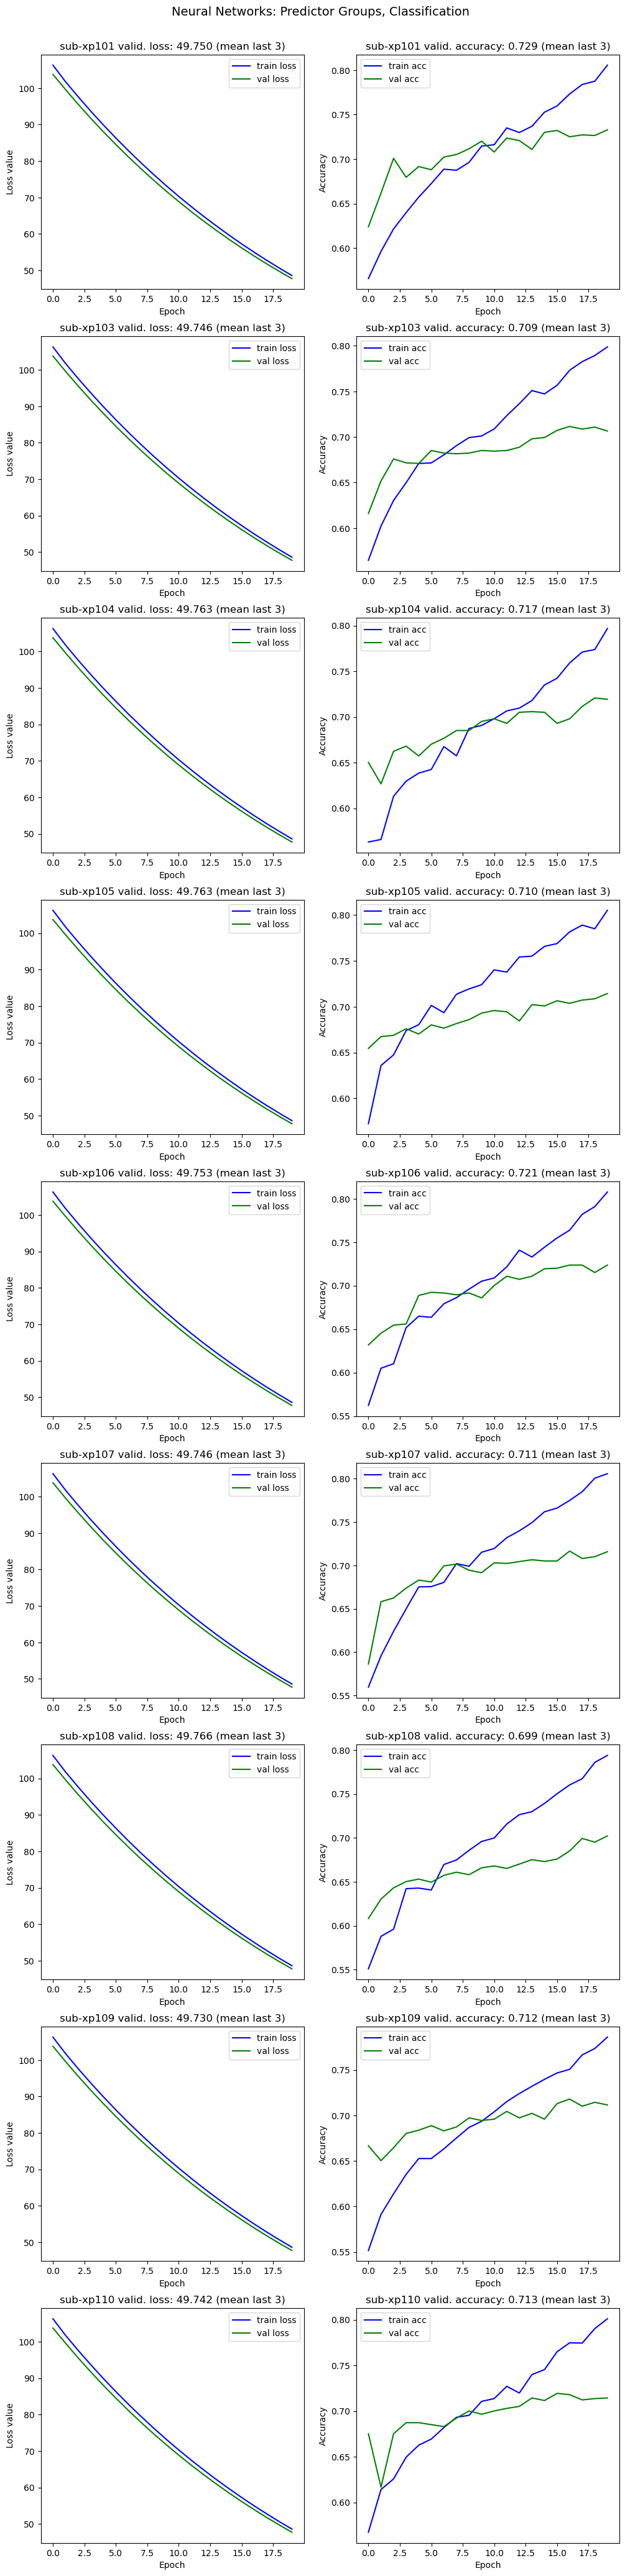

In [18]:
# Display the results. 
plot_neural_network_classification(dict_history_pg_class, title = 'Neural Networks: Predictor Groups, Classification')

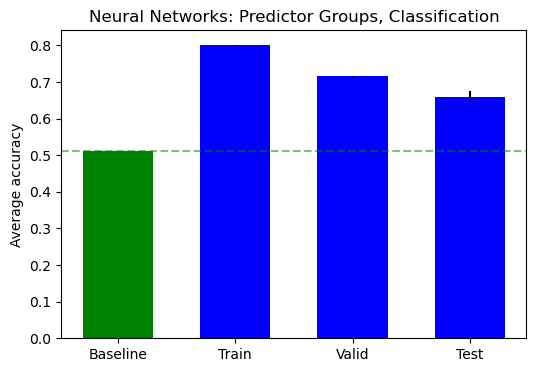

In [19]:
# Retrieve the average accuracy and the standard error of the accuracy. 
acc = [df_summary_pg_class['score_baseline'].mean(), 
       df_summary_pg_class['score_train'].mean(), 
       df_summary_pg_class['score_valid'].mean(), 
       df_summary_pg_class['score_test'].mean()]
acc_se = [np.std(df_summary_pg_class['score_baseline']) / np.sqrt(df_summary_pg_class['score_baseline'].shape[0]), 
          np.std(df_summary_pg_class['score_train']) / np.sqrt(df_summary_pg_class['score_train'].shape[0]), 
          np.std(df_summary_pg_class['score_valid']) / np.sqrt(df_summary_pg_class['score_valid'].shape[0]), 
          np.std(df_summary_pg_class['score_test']) / np.sqrt(df_summary_pg_class['score_test'].shape[0])]

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average accuracy')
axes.set_title('Neural Networks: Predictor Groups, Classification');

## **2. Regression**

- **Task**: We train a neural network model on our regression task of interest, on all subjects except sub-xp102 who has a missing condition. 

- **Model**: We use mostly the same model than for the classification task, but with the Adam optimizer and the Mean Squared Error (MSE) loss. Our objective is to minimize the regression Mean Absolute Error (MAE). 

- **Strategies**: The Predictor Brains strategy and the Predictor Groups strategy are defined as in the classification task. 

- **Results**: For the Predictor Brains strategy, the neural network model typically beats the baseline for the train set and the validation set, but stays at the baseline level for the test set, indicating a lack of generalization. For the Predictor Groups strategy, the neural network model stays at the baseline level for the train set, the validation set, and the test set. For both strategies, the predictions are essentially similar to the baseline. 

In [20]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [21]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [22]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [23]:
# Define a function to run a neural network model for the Predictor Brains strategy, for a regression task. 
def run_neural_network_predictor_brains_regression(NeuralNetworkModel, dict_features_sequence, dict_targets_sequence, dict_baseline_sequence):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the features of the train set, validation set, and test set. 
        X_tr = dict_features_sequence[subject]['eegfmriNF']
        X_va = dict_features_sequence[subject]['eegNF']
        X_te = dict_features_sequence[subject]['fmriNF']

        # Retrieve the targets of the train set, validation set, and test set. 
        Y_tr = dict_targets_sequence[subject]['eegfmriNF']
        Y_va = dict_targets_sequence[subject]['eegNF']
        Y_te = dict_targets_sequence[subject]['fmriNF']

        # Retrieve the baseline of the train set. 
        Baseline = dict_baseline_sequence[subject]['eegfmriNF']

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_standardized = scaler.fit_transform(X_tr)
        X_va_standardized = scaler.transform(X_va)
        X_te_standardized = scaler.transform(X_te)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

        # Define the loss function, optimizer, and metrics to track during training. 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.005, beta_1 = 0.9)
        PredictorBrain.compile(optimizer = optimizer, loss = 'mse', metrics = [tf.keras.metrics.MeanAbsoluteError()])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = Y_tr,
            validation_data = (X_va_standardized, Y_va), 
            batch_size = batch_size, epochs = 50, 
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test score. 
        (mse_test, mae_test) = PredictorBrain.evaluate(X_te_standardized, Y_te, batch_size = batch_size)

        # Compute the predictions from the neural network, and compute the accuracy from these predictions. 
        Y_pred = PredictorBrain.predict(X_te_standardized)

        # Evaluate the performance metrics. 
        mse_baseline = MSE(Y_te, Baseline)
        mae_baseline = MAE(Y_te, Baseline)
        rss_baseline = RSS(Y_te, Baseline)
        mse_model = MSE(Y_te, Y_pred)
        mae_model = MAE(Y_te, Y_pred)
        rss_model = RSS(Y_te, Y_pred)
        r2_model = 1 - (rss_model / rss_baseline)

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'mse_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'mse_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'mse_test'] = mse_test
        df_summary.loc[subject, 'mae_train'] = NeuralNetworkHistory.history['mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_valid'] = NeuralNetworkHistory.history['val_mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_test'] = mae_test
        df_summary.loc[subject, 'mae_baseline'] = mae_baseline
        df_summary.loc[subject, 'r2_model'] = r2_model
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'Y_tr.shape'] = str(Y_tr.shape)
        df_summary.loc[subject, 'Y_va.shape'] = str(Y_va.shape)
        df_summary.loc[subject, 'Y_te.shape'] = str(Y_te.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = Y_pred
    
    return dict_models, dict_history, dict_predictions, df_summary

In [24]:
# Define a function to run a neural network model for the Predictor Groups strategy, for a regression task. 
def run_neural_network_predictor_groups_regression(NeuralNetworkModel, dict_features_sequence, dict_targets_sequence, dict_baseline_sequence):

    # Determine the proportion of the validation set. 
    validation_set_proportion = 0.3

    # Define the dictionaries and the summary DataFrame. 
    dict_scaler = dict()
    dict_shapes = dict()
    dict_mean_baseline = dict()
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # TRAINING LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorGroup = tf.keras.models.clone_model(NeuralNetworkModel)

        # Define the lists to store the features, targets, and baseline for the train+valid set. 
        features_list = []
        targets_list = []
        baseline_list = []

        # Iterate through all subjects, except for the subject whose targets we are trying to predict. 
        for subject_predictor in subjects:

            # Skip the current iteration for the current subject. 
            if subject_predictor == subject:
                continue

            # Iterate through all conditions. 
            for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

                # Retrieve the features, targets, and baseline, and add them to the list. 
                features_list.append(dict_features_sequence[subject_predictor][condition])
                targets_list.append(dict_targets_sequence[subject_predictor][condition])
                baseline_list.append(dict_baseline_sequence[subject_predictor][condition])
        
        # Retrieve the features and targets of the train+validation set. 
        X = np.vstack(features_list)
        Y = np.vstack(targets_list)
        Baseline = np.array(baseline_list).mean(axis = 0)

        # Divide the data into a train set and a validation set. 
        X_tr, X_va, Y_tr, Y_va = train_test_split(X, Y, test_size = validation_set_proportion)

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_standardized = scaler.fit_transform(X_tr)
        X_va_standardized = scaler.transform(X_va)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6)

        # Define the loss function, optimizer, and metrics to track during training. 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.005, beta_1 = 0.9)
        PredictorGroup.compile(optimizer = optimizer, loss = 'mse', metrics = [tf.keras.metrics.MeanAbsoluteError()])

        # Fit the model. 
        NeuralNetworkHistory = PredictorGroup.fit(
            x = X_tr_standardized, y = Y_tr,
            validation_data = (X_va_standardized, Y_va), 
            batch_size = batch_size, epochs = 20, 
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Store the scaler, shapes of arrays, mean baseline, trained model, and history in dictionaries. 
        dict_scaler[subject] = scaler
        dict_shapes[subject] = [X_tr_standardized.shape, X_va_standardized.shape, Y_tr.shape, Y_va.shape]
        dict_mean_baseline[subject] = Baseline
        dict_models[subject] = PredictorGroup
        dict_history[subject] = NeuralNetworkHistory

    # PREDICTION LOOP. Iterate through all subjects. 
    for subject in subjects:

        # Define the subject dictionary. 
        dict_predictions[subject] = dict()

        # Iterate through all conditions. 
        for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

            # Retrieve the features and targets of the test set, the baseline, the trained model, and the history. 
            X_te = dict_features_sequence[subject][condition]
            Y_te = dict_targets_sequence[subject][condition]
            Baseline = dict_mean_baseline[subject]
            PredictorGroup = dict_models[subject]
            NeuralNetworkHistory = dict_history[subject]

            # Rescale features variables. 
            scaler = dict_scaler[subject]
            X_te_standardized = scaler.transform(X_te)

            # Evaluate the test score. 
            (mse_test, mae_test) = PredictorGroup.evaluate(X_te_standardized, Y_te, batch_size = batch_size)

            # Compute the predictions from the neural network. 
            Y_pred = PredictorGroup.predict(X_te_standardized)

            # Evaluate the performance metrics. 
            mse_baseline = MSE(Y_te, Baseline)
            mae_baseline = MAE(Y_te, Baseline)
            rss_baseline = RSS(Y_te, Baseline)
            mse_model = MSE(Y_te, Y_pred)
            mae_model = MAE(Y_te, Y_pred)
            rss_model = RSS(Y_te, Y_pred)
            r2_model = 1 - (rss_model / rss_baseline)

            # Retrieve the shapes of the arrays from the train set. 
            [X_tr_shape, X_va_shape, Y_tr_shape, Y_va_shape] = dict_shapes[subject]

            # Store the performance metrics and the shapes of the arrays in the DataFrame. 
            df_summary.loc[subject + '/' + condition, 'subject'] = subject
            df_summary.loc[subject + '/' + condition, 'condition'] = condition
            df_summary.loc[subject + '/' + condition, 'mse_train'] = NeuralNetworkHistory.history['loss'][-1]
            df_summary.loc[subject + '/' + condition, 'mse_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
            df_summary.loc[subject + '/' + condition, 'mse_test'] = mse_test
            df_summary.loc[subject + '/' + condition, 'mae_train'] = NeuralNetworkHistory.history['mean_absolute_error'][-1]
            df_summary.loc[subject + '/' + condition, 'mae_valid'] = NeuralNetworkHistory.history['val_mean_absolute_error'][-1]
            df_summary.loc[subject + '/' + condition, 'mae_test'] = mae_test
            df_summary.loc[subject + '/' + condition, 'mae_baseline'] = mae_baseline
            df_summary.loc[subject + '/' + condition, 'r2_model'] = r2_model
            df_summary.loc[subject + '/' + condition, 'X_tr.shape'] = str(X_tr_shape)
            df_summary.loc[subject + '/' + condition, 'X_va.shape'] = str(X_va_shape)
            df_summary.loc[subject + '/' + condition, 'X_te.shape'] = str(X_te_standardized.shape)
            df_summary.loc[subject + '/' + condition, 'Y_tr.shape'] = str(Y_tr_shape)
            df_summary.loc[subject + '/' + condition, 'Y_va.shape'] = str(Y_va_shape)
            df_summary.loc[subject + '/' + condition, 'Y_te.shape'] = str(Y_te.shape)

            # Store the predictions in the dictionary. 
            dict_predictions[subject][condition] = Y_pred

    # Change the indexes of the DataFrame. 
    df_summary = df_summary.set_index(['subject', 'condition'])
    
    return dict_models, dict_history, dict_predictions, dict_mean_baseline, df_summary

In [25]:
# Define a function to plot the results of the neural network training. 
def plot_neural_network_regression(dict_history_reg, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_reg[subject]

        # Plot MSE values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train MSE', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val MSE', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. MSE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('MSE')
        axes[subject_index, 0].legend()

        # Plot MAE values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['mean_absolute_error'], label = 'train MAE', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_mean_absolute_error'], label = 'val MAE', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. MAE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_mean_absolute_error'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('MAE')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [26]:
# Define the neural network model. 
tf.random.set_seed(0)
NeuralNetworkModel = tf.keras.Sequential()

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 4096, activation = tf.keras.activations.relu, input_dim = dict_features_sequence[subject]['eegfmriNF'].shape[1], 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5, seed = 0))

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 1024, activation = tf.keras.activations.relu, 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5, seed = 0))

# Dense layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = 256, activation = tf.keras.activations.relu, 
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 2.0, seed = 0),
    kernel_regularizer = tf.keras.regularizers.l2(0.01), bias_regularizer = tf.keras.regularizers.l2(0.01)
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5, seed = 0))

# Output layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = dict_targets_sequence[subject]['eegfmriNF'].shape[1], 
    ))

# Print network summary. 
NeuralNetworkModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              9293824   
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              4195328   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               262400    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 17)               

In [27]:
# Run the neural network model. 
dict_models_pb_reg, dict_history_pb_reg, dict_predictions_pb_reg, df_summary_pb_reg = run_neural_network_predictor_brains_regression(NeuralNetworkModel, 
                                                                                                                                     dict_features_sequence, 
                                                                                                                                     dict_targets_sequence, 
                                                                                                                                     dict_baseline_sequence)

sub-xp101
7/7 [==============================] - 0s 3ms/step
sub-xp103
7/7 [==============================] - 0s 4ms/step
sub-xp104
7/7 [==============================] - 0s 4ms/step
sub-xp105
7/7 [==============================] - 0s 4ms/step
sub-xp106
7/7 [==============================] - 0s 3ms/step
sub-xp107
7/7 [==============================] - 0s 3ms/step
sub-xp108
7/7 [==============================] - 0s 3ms/step
sub-xp109
7/7 [==============================] - 0s 4ms/step
sub-xp110
7/7 [==============================] - 0s 3ms/step


In [28]:
# Display the results. 
print('Neural Networks: Predictor Brains, Regression')
df_summary_pb_reg

Neural Networks: Predictor Brains, Regression


,mse_train,mse_valid,mse_test,mae_train,mae_valid,mae_test,mae_baseline,r2_model,X_tr.shape,X_va.shape,X_te.shape,Y_tr.shape,Y_va.shape,Y_te.shape
sub-xp101,5.831443,5.599726,5.686157,0.778828,0.724366,0.761975,0.761400,-0.000453,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"
sub-xp103,2.390321,2.350428,2.347255,0.798043,0.797947,0.793294,0.793431,0.000646,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"
sub-xp104,1.866632,1.807377,1.907730,0.735717,0.717436,0.768316,0.768766,0.000991,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"
sub-xp105,2.192264,2.376050,2.380117,0.785228,0.774505,0.788634,0.788395,-0.000974,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"
sub-xp106,3.306537,3.245084,3.255685,0.777147,0.782820,0.792897,0.793431,0.000303,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"
sub-xp107,3.014107,2.960918,2.949429,0.785040,0.781766,0.780539,0.782540,0.006313,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"
sub-xp108,4.348771,4.252783,4.260596,0.792919,0.800805,0.799697,0.799883,0.000032,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"
sub-xp109,2.180661,2.151646,2.154557,0.777833,0.789829,0.796022,0.798910,0.003811,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"
sub-xp110,2.242446,2.237856,2.230510,0.777931,0.787050,0.786607,0.790629,0.004931,"(195, 2268)","(195, 2268)","(195, 2268)","(195, 17)","(195, 17)","(195, 17)"


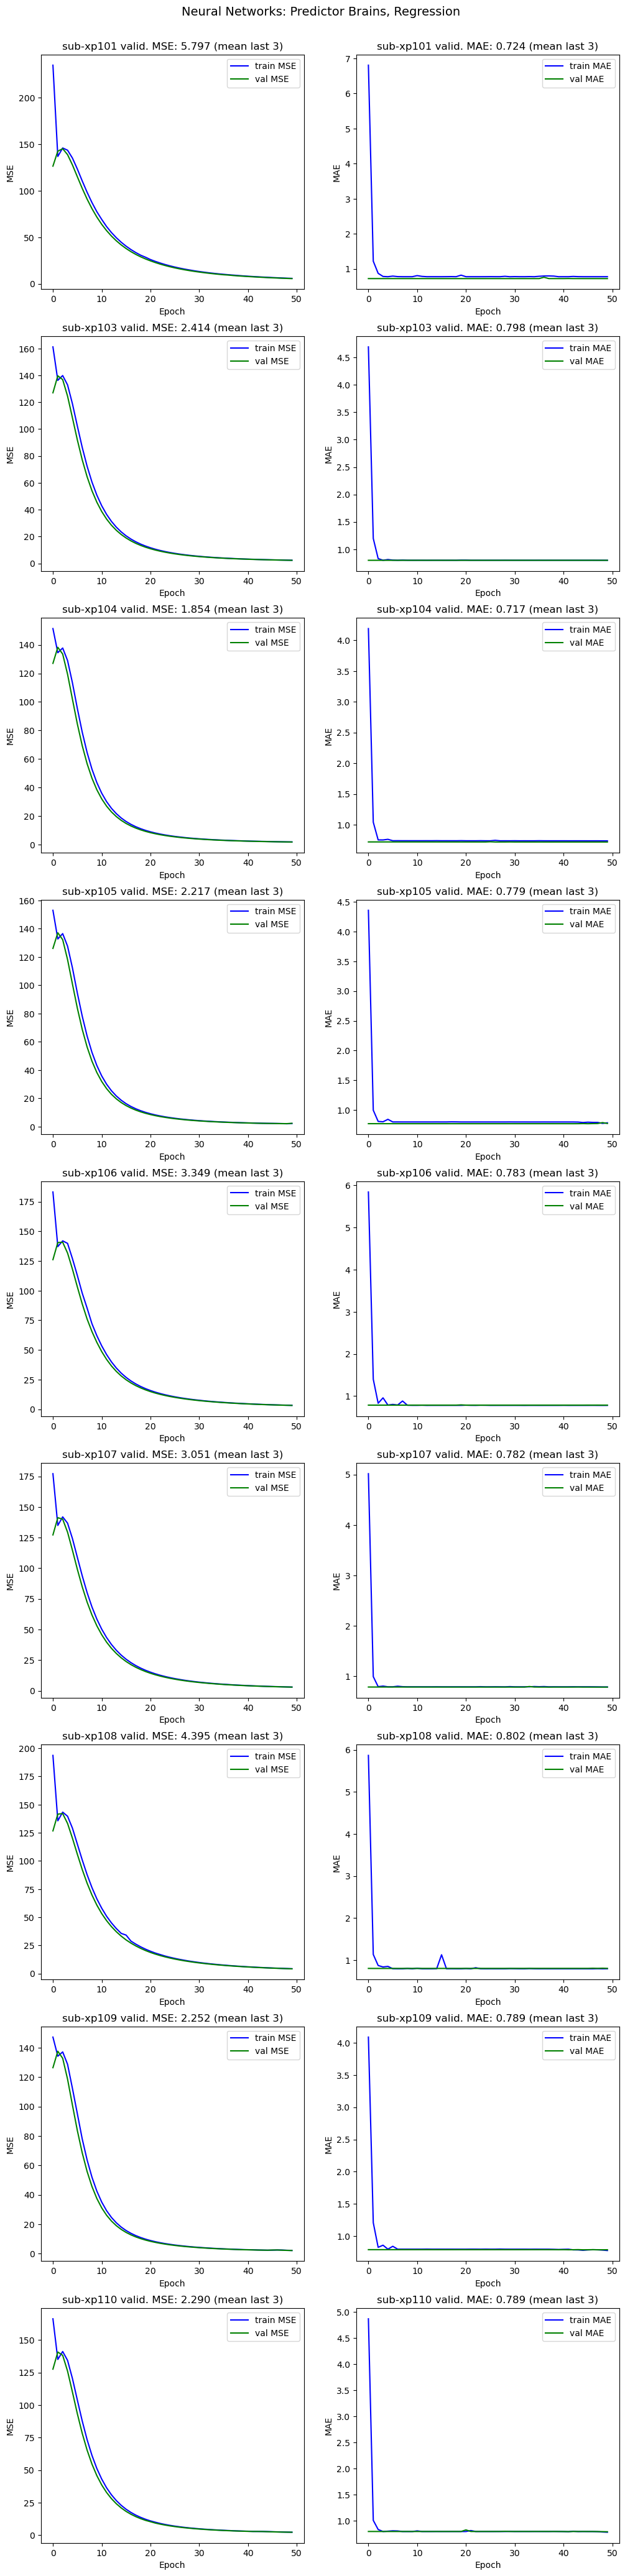

In [29]:
# Display the results. 
plot_neural_network_regression(dict_history_pb_reg, title = 'Neural Networks: Predictor Brains, Regression')

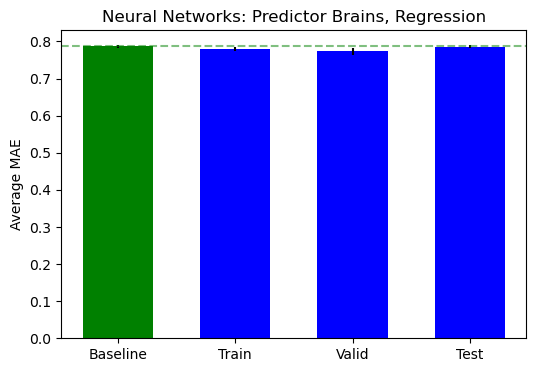

In [30]:
# Retrieve the average MAE and the standard error of the MAE. 
acc = [df_summary_pb_reg['mae_baseline'].mean(), 
       df_summary_pb_reg['mae_train'].mean(), 
       df_summary_pb_reg['mae_valid'].mean(), 
       df_summary_pb_reg['mae_test'].mean()]
acc_se = [np.std(df_summary_pb_reg['mae_baseline']) / np.sqrt(df_summary_pb_reg['mae_baseline'].shape[0]), 
          np.std(df_summary_pb_reg['mae_train']) / np.sqrt(df_summary_pb_reg['mae_train'].shape[0]), 
          np.std(df_summary_pb_reg['mae_valid']) / np.sqrt(df_summary_pb_reg['mae_valid'].shape[0]), 
          np.std(df_summary_pb_reg['mae_test']) / np.sqrt(df_summary_pb_reg['mae_test'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average MAE')
axes.set_title('Neural Networks: Predictor Brains, Regression');

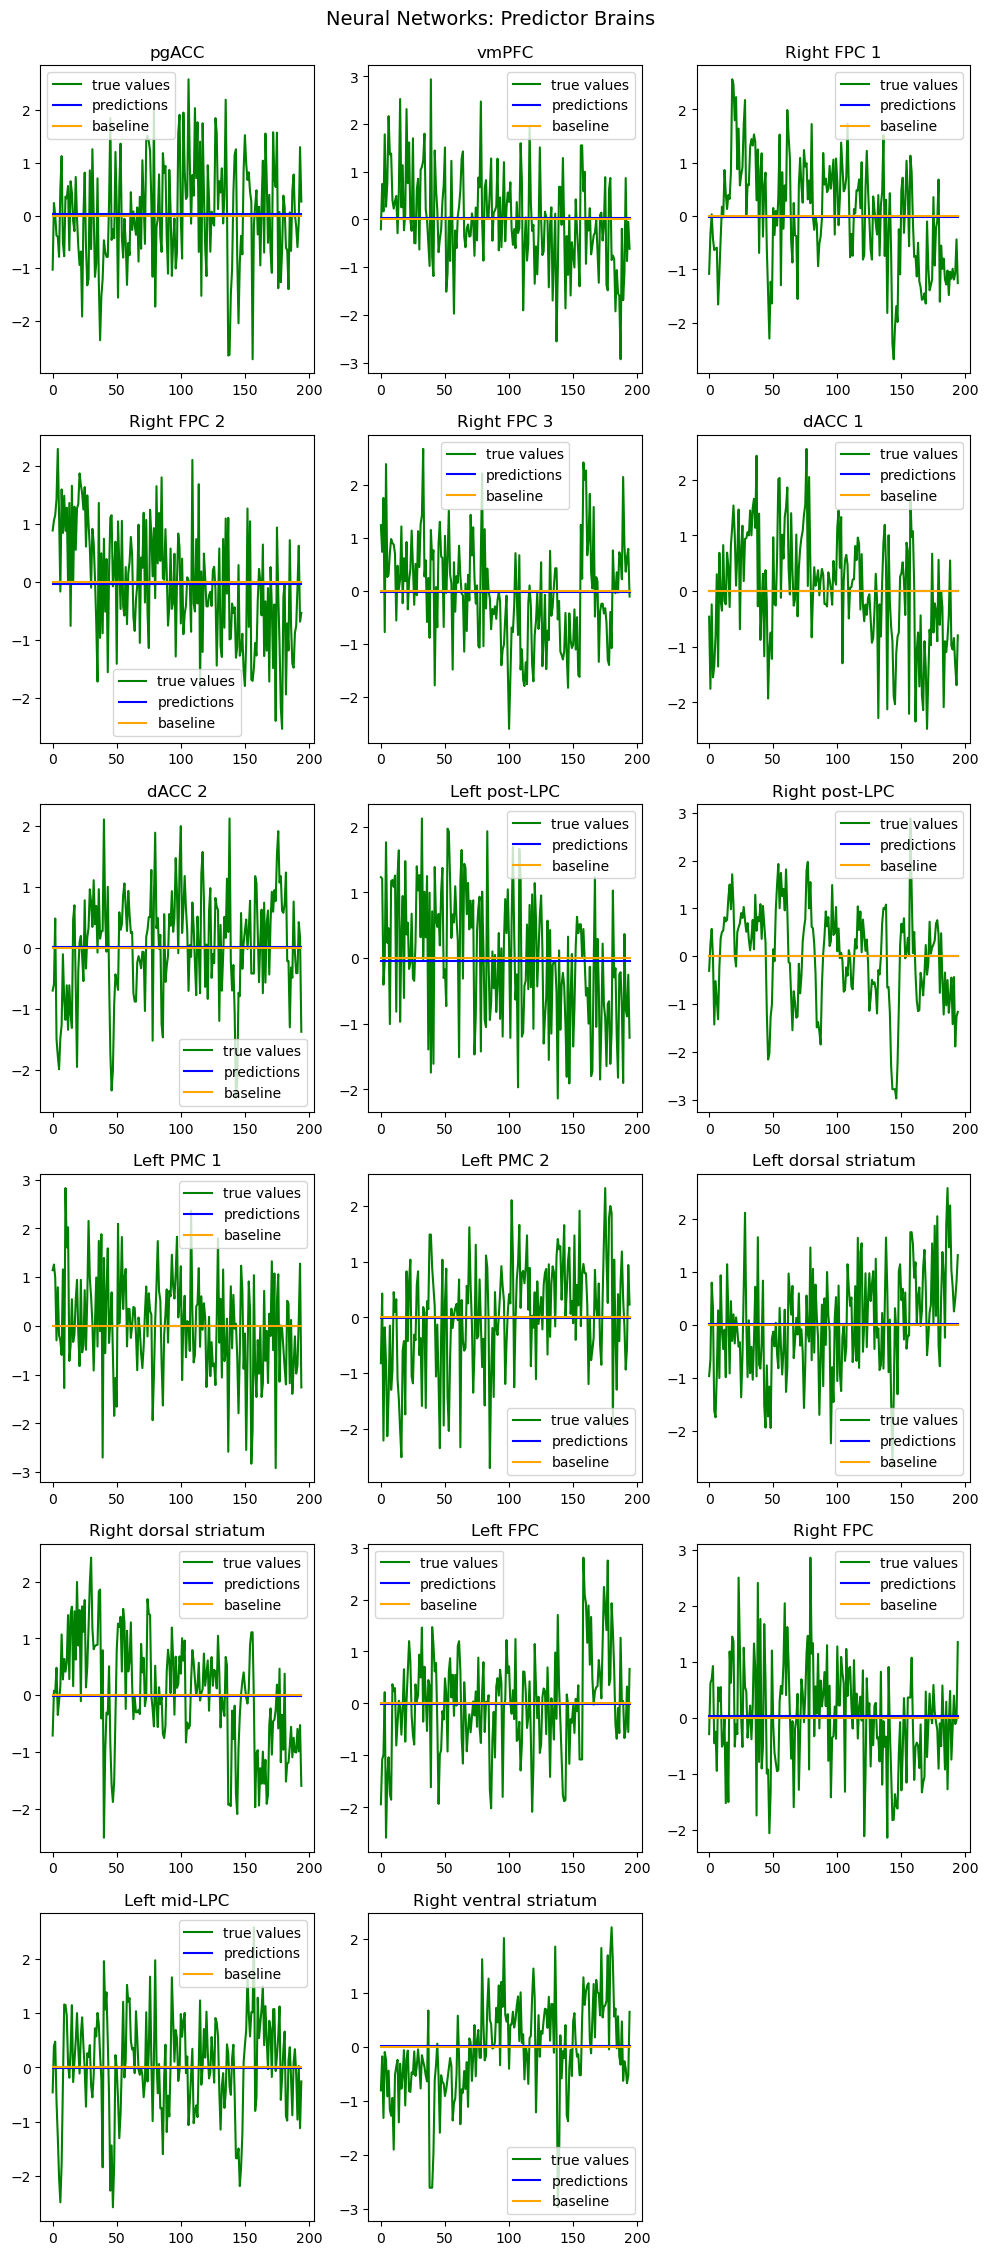

In [31]:
# Plot the true values, the predictions, and the baseline for all the targets voxels. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (12, 28))
fig.suptitle('Neural Networks: Predictor Brains', fontsize = 14, y = 0.9)
subject = subjects[0]

# Iterate through all target voxels. 
for target_index in range(len(targets)):

    # Retrieve the true values, the predictions, and the baseline for the selected subject and sequence length. 
    Y_te = dict_targets_sequence[subject]['fmriNF'][:, target_index]
    Y_pred = dict_predictions_pb_reg[subject][:, target_index]
    Baseline = dict_baseline_sequence[subject]['eegfmriNF'][:, target_index]

    # Compute the row and column indexes. 
    row_index = target_index // 3
    column_index = target_index % 3

    # Plot the true values, the predictions, and the baseline. 
    axes[row_index, column_index].plot(Y_te,  color = 'green', label = 'true values')
    axes[row_index, column_index].plot(Y_pred,  color = 'blue', label = 'predictions')
    axes[row_index, column_index].plot(Baseline,  color = 'orange', label = 'baseline')
    axes[row_index, column_index].legend()
    axes[row_index, column_index].set_title(targets[target_index])

# Hide empty subplot. 
axes[5, 2].set_visible(False)

In [32]:
# Run the neural network model. 
dict_models_pg_reg, dict_history_pg_reg, dict_predictions_pg_reg, dict_mean_baseline_pg_reg, df_summary_pg_reg = run_neural_network_predictor_groups_regression(NeuralNetworkModel, 
                                                                                                                                                                dict_features_sequence, 
                                                                                                                                                                dict_targets_sequence, 
                                                                                                                                                                dict_baseline_sequence)

sub-xp101
sub-xp103
sub-xp104
sub-xp105
sub-xp106
sub-xp107
sub-xp108
sub-xp109
sub-xp110
7/7 [==============================] - 0s 4ms/step


In [33]:
# Display the results. 
print('Neural Networks: Predictor Groups, Regression')
df_summary_pg_reg

Neural Networks: Predictor Groups, Regression


mse_train  mse_valid  mse_test  mae_train  mae_valid  \
subject   condition                                                         
sub-xp101 eegNF       0.985867   0.954040  0.850923   0.789336   0.775123   
          fmriNF      0.985867   0.954040  0.936479   0.789336   0.775123   
          eegfmriNF   0.985867   0.954040  0.960882   0.789336   0.775123   
sub-xp103 eegNF       0.958239   0.957371  0.989249   0.779224   0.781054   
          fmriNF      0.958239   0.957371  0.986914   0.779224   0.781054   
          eegfmriNF   0.958239   0.957371  0.992533   0.779224   0.781054   
sub-xp104 eegNF       0.962747   0.981723  0.832430   0.783838   0.793054   
          fmriNF      0.962747   0.981723  0.932336   0.783838   0.793054   
          eegfmriNF   0.962747   0.981723  0.865343   0.783838   0.793054   
sub-xp105 eegNF       0.989890   0.974738  0.978391   0.783078   0.776188   
          fmriNF      0.989890   0.974738  0.991688   0.783078   0.776188   
          eegfmriNF   0.989890   0.974738  1.002619   0.783078   0.776188   
sub-xp106 eegNF       0.952330   0.958876  0.958533   0.780336   0.783549   
          fmriNF      0.952330   0.958876  0.969375   0.780336   0.783549   
          eegfmriNF   0.952330   0.958876  0.955053   0.780336   0.783549   
sub-xp107 eegNF       0.959044   0.955788  0.970963   0.781798   0.780205   
          fmriNF      0.959044   0.955788  0.966732   0.781798   0.780205   
          eegfmriNF   0.959044   0.955788  0.974681   0.781798   0.780205   
sub-xp108 eegNF       0.965279   0.956886  0.992280   0.780452   0.778061   
          fmriNF      0.965279   0.956886  1.000983   0.780452   0.778061   
          eegfmriNF   0.965279   0.956886  0.997396   0.780452   0.778061   
sub-xp109 eegNF       0.963641   0.996975  0.994028   0.775081   0.790547   
          fmriNF      0.963641   0.996975  0.998827   0.775081   0.790547   
          eegfmriNF   0.963641   0.996975  1.008796   0.775081   0.790547   
sub-xp110 eegNF       0.954049   0.947477  0.970664   0.780916   0.779252   
          fmriNF      0.954049   0.947477  0.962309   0.780916   0.779252   
          eegfmriNF   0.954049   0.947477  0.982833   0.780916   0.779252   

                     mae_test  mae_baseline  r2_model    X_tr.shape  \
subject   condition                                                   
sub-xp101 eegNF      0.724016      0.724528 -0.000334  (3276, 2268)   
          fmriNF     0.761015      0.761400  0.000038  (3276, 2268)   
          eegfmriNF  0.778936      0.778745 -0.000195  (3276, 2268)   
sub-xp103 eegNF      0.798147      0.798019 -0.000350  (3276, 2268)   
          fmriNF     0.793847      0.793431 -0.000572  (3276, 2268)   
          eegfmriNF  0.798496      0.798496 -0.000125  (3276, 2268)   
sub-xp104 eegNF      0.718727      0.718694 -0.000142  (3276, 2268)   
          fmriNF     0.768901      0.768766 -0.000301  (3276, 2268)   
          eegfmriNF  0.738117      0.738343 -0.000246  (3276, 2268)   
sub-xp105 eegNF      0.770901      0.771004  0.000029  (3276, 2268)   
          fmriNF     0.788797      0.788395 -0.000401  (3276, 2268)   
          eegfmriNF  0.800094      0.799988 -0.000005  (3276, 2268)   
sub-xp106 eegNF      0.782959      0.783151  0.000227  (3276, 2268)   
          fmriNF     0.793123      0.793431  0.000269  (3276, 2268)   
          eegfmriNF  0.777709      0.778046  0.000351  (3276, 2268)   
sub-xp107 eegNF      0.783388      0.783571 -0.000428  (3276, 2268)   
          fmriNF     0.782669      0.782540 -0.000135  (3276, 2268)   
          eegfmriNF  0.787925      0.788009  0.000008  (3276, 2268)   
sub-xp108 eegNF      0.799947      0.799989 -0.000095  (3276, 2268)   
          fmriNF     0.799792      0.799883 -0.000433  (3276, 2268)   
          eegfmriNF  0.791423      0.791512 -0.000042  (3276, 2268)   
sub-xp109 eegNF      0.791595      0.791141 -0.000265  (3276, 2268)   
          fmriNF     0.799030      0.798910 -0.000434  (3276, 2268)   
          ee

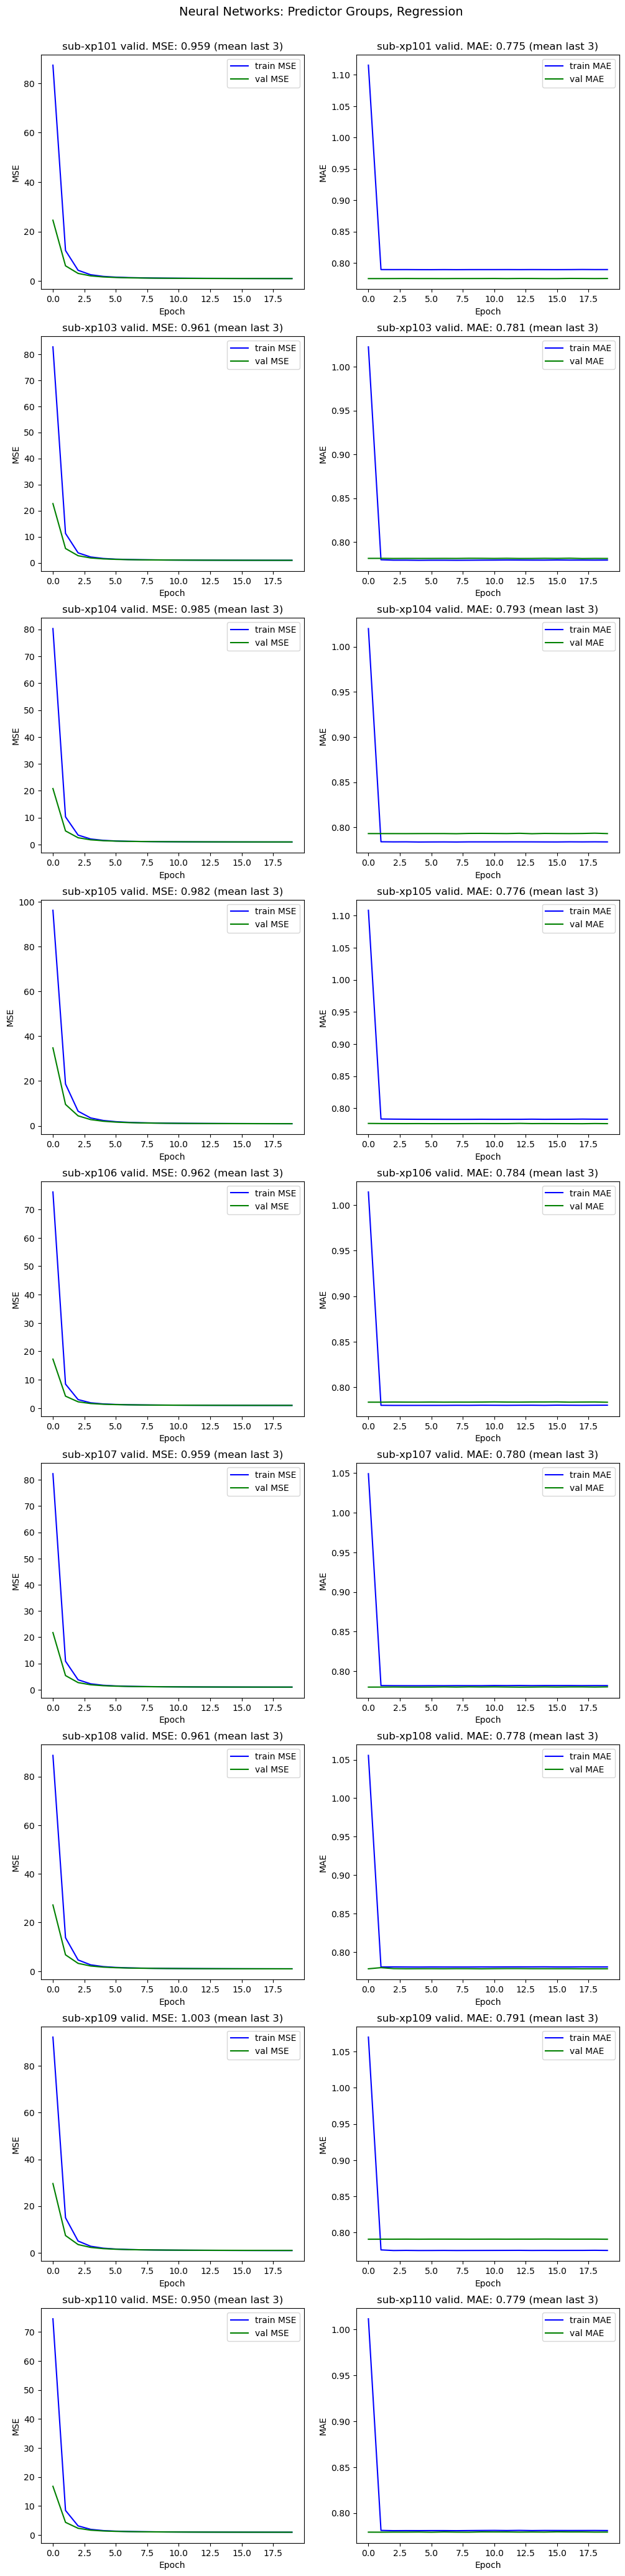

In [34]:
# Display the results. 
plot_neural_network_regression(dict_history_pg_reg, title = 'Neural Networks: Predictor Groups, Regression')

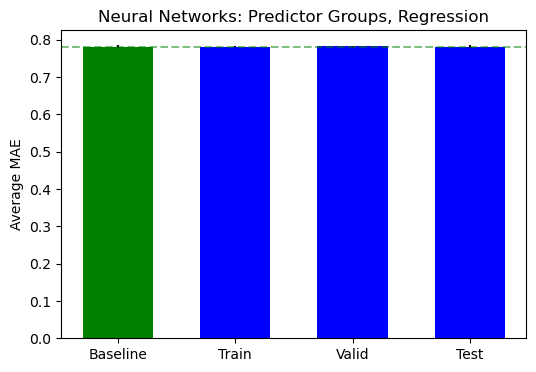

In [35]:
# Retrieve the average MAE and the standard error of the MAE. 
acc = [df_summary_pg_reg['mae_baseline'].mean(), 
       df_summary_pg_reg['mae_train'].mean(), 
       df_summary_pg_reg['mae_valid'].mean(), 
       df_summary_pg_reg['mae_test'].mean()]
acc_se = [np.std(df_summary_pg_reg['mae_baseline']) / np.sqrt(df_summary_pg_reg['mae_baseline'].shape[0]), 
          np.std(df_summary_pg_reg['mae_train']) / np.sqrt(df_summary_pg_reg['mae_train'].shape[0]), 
          np.std(df_summary_pg_reg['mae_valid']) / np.sqrt(df_summary_pg_reg['mae_valid'].shape[0]), 
          np.std(df_summary_pg_reg['mae_test']) / np.sqrt(df_summary_pg_reg['mae_test'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average MAE')
axes.set_title('Neural Networks: Predictor Groups, Regression');

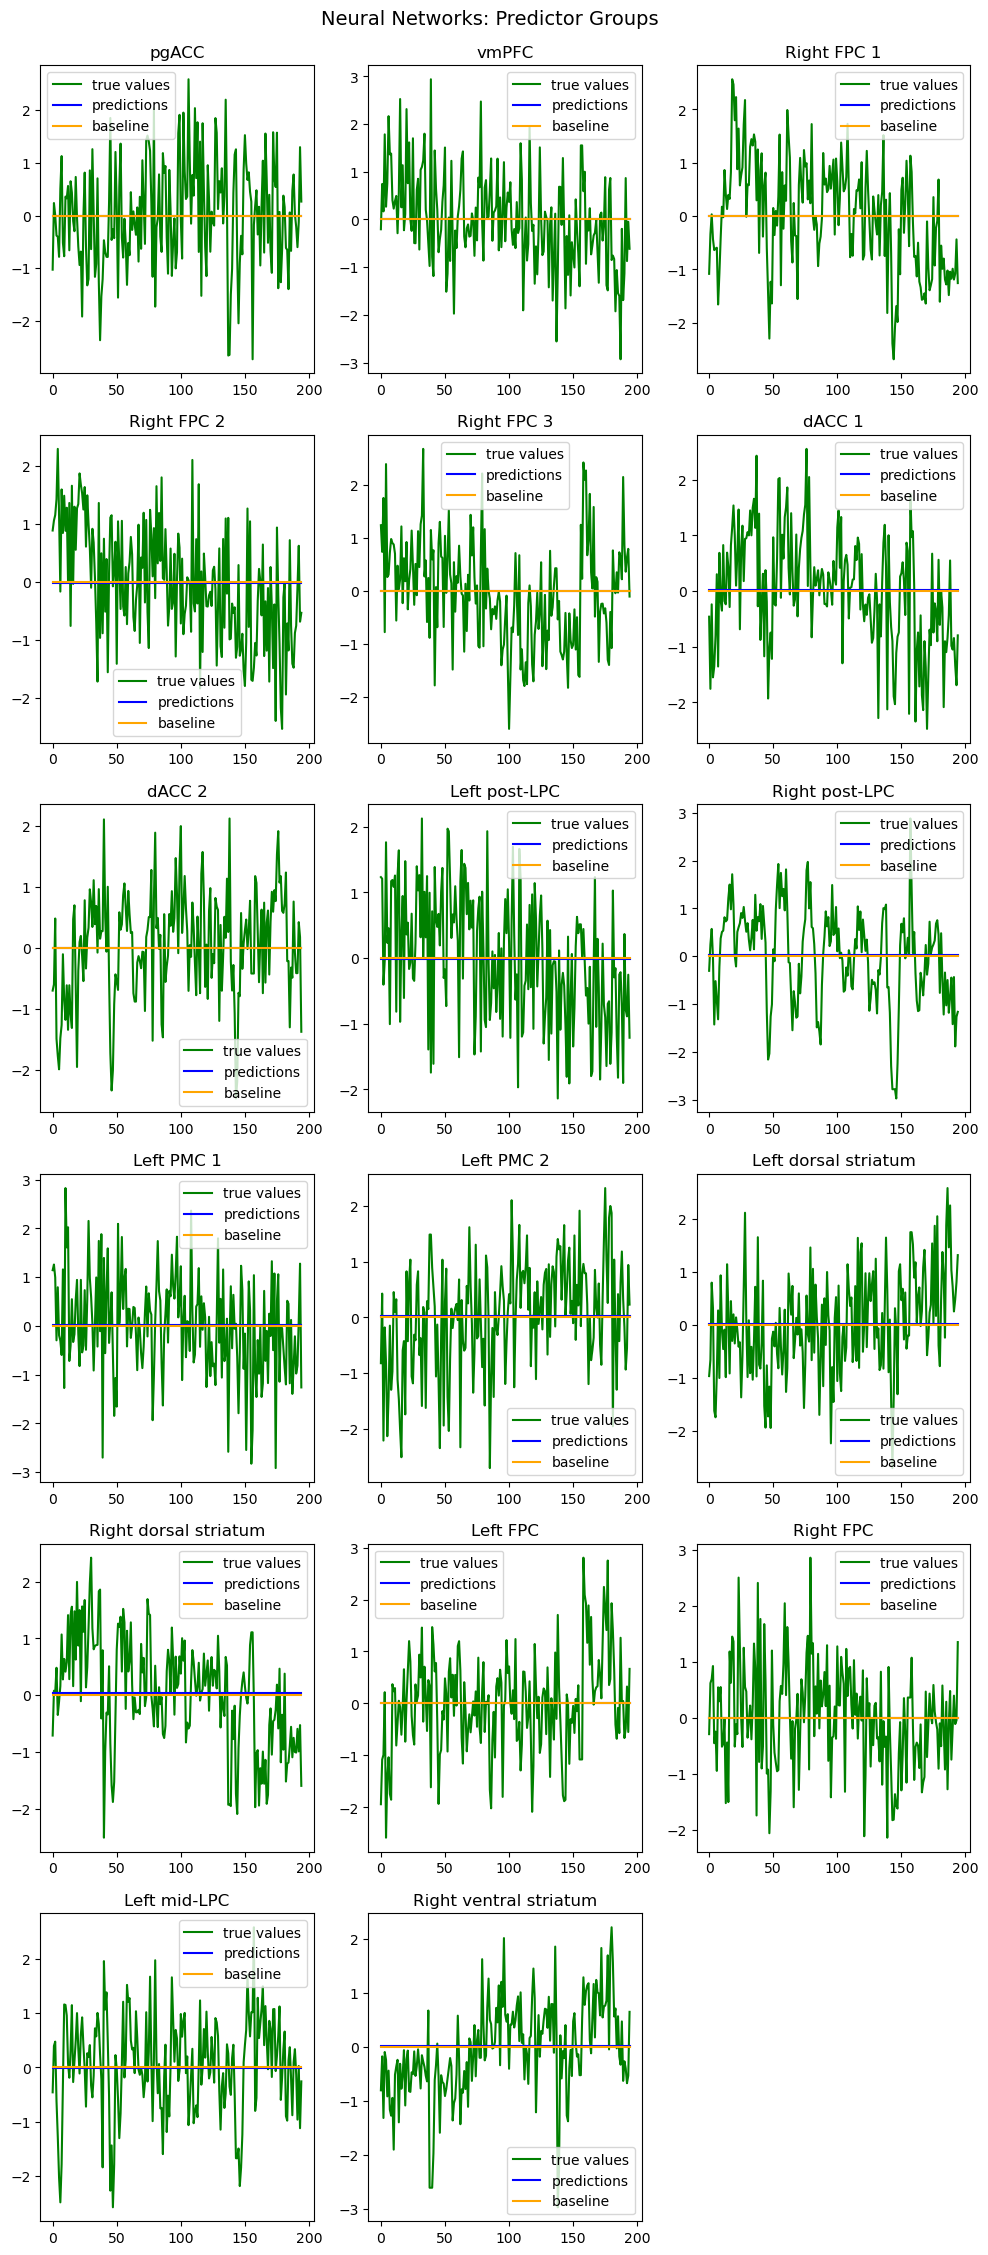

In [36]:
# Plot the true values, the predictions, and the baseline for all the targets voxels. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (12, 28))
fig.suptitle('Neural Networks: Predictor Groups', fontsize = 14, y = 0.9)
subject = subjects[0]

# Iterate through all target voxels. 
for target_index in range(len(targets)):

    # Retrieve the true values, the predictions, and the baseline for the selected subject and sequence length. 
    Y_te = dict_targets_sequence[subject]['fmriNF'][:, target_index]
    Y_pred = dict_predictions_pg_reg[subject]['fmriNF'][:, target_index]
    Baseline = dict_mean_baseline_pg_reg[subject][:, target_index]

    # Compute the row and column indexes. 
    row_index = target_index // 3
    column_index = target_index % 3

    # Plot the true values, the predictions, and the baseline. 
    axes[row_index, column_index].plot(Y_te,  color = 'green', label = 'true values')
    axes[row_index, column_index].plot(Y_pred,  color = 'blue', label = 'predictions')
    axes[row_index, column_index].plot(Baseline,  color = 'orange', label = 'baseline')
    axes[row_index, column_index].legend()
    axes[row_index, column_index].set_title(targets[target_index])

# Hide empty subplot. 
axes[5, 2].set_visible(False)

In [37]:
# Save the regression models into Pickle files. 
with open(results_path + 'dict_models_neural_networks_pb_reg.p', 'wb') as file:
    pickle.dump(dict_models_pb_reg, file)
with open(results_path + 'dict_models_neural_networks_pg_reg.p', 'wb') as file:
    pickle.dump(dict_models_pg_reg, file)